# Project 3 - SME808
* Leonardo Meireles - NUSP: 4182085
* Antonio Moreira - NUSP: 9779242

## Objective
* Dynamic Linear Models
* TS Final project

In [21]:
# Basic packages
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd  # generating random numbers
import datetime  # manipulating date formats
# Viz
import matplotlib.pyplot as plt  # basic plotting
import matplotlib.dates as mdates
import seaborn as sns  # for prettier plots
import matplotlib.style as style
plt.style.use('fivethirtyeight')

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import scipy.special as sc
from pydlm import dlm, trend, seasonality

plt.rcParams.update({'figure.figsize': (12, 6)})

# settings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def tsplot(df, target, lags=None, figsize=(12, 6), style='fivethirtyeight', title=''):
    y = df[target].values
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 1)
        # Defining the subplot axes
        #ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 0))
        
        #df.plot(y=target, ax=ts_ax, legend=False)
        #ts_ax.set_title(title)
        # Auto correlation plot(MA)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5, title='FAC')
        # Parcial ACF(AR)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5, title='FACP')

        plt.tight_layout()
        plt.plot()

https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html

### Description
The classic Box & Jenkins airline data. Monthly totals of international airline passengers, 1949 to 1960.

### Format
A monthly time series, in thousands.

### Source
Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.

In [3]:
df = pd.read_csv('../data/AirPassengers.csv')
df['Month'] = pd.to_datetime(df.Month)

In [4]:
df = df.rename(columns={'Month': 'Mês', '#Passengers': '#Passageiros'})

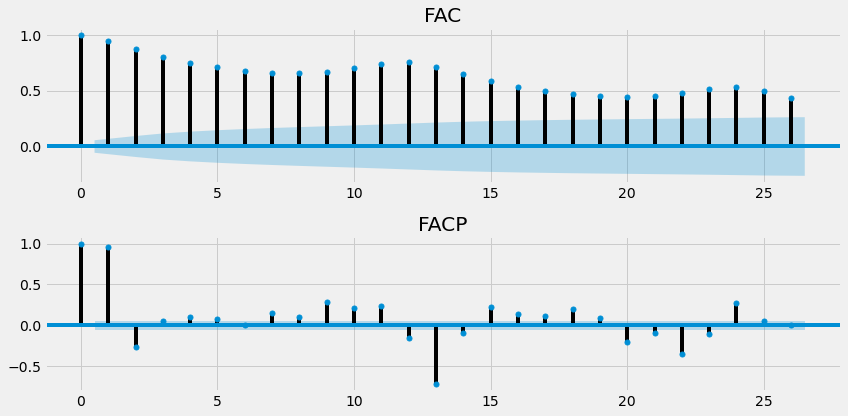

In [5]:
df_o = df.set_index('Mês').copy()
tsplot(df_o, '#Passageiros', title='Tráfego mensal de passageiros em voos internacionais', figsize=(12, 6), lags=26)
plt.savefig('../images/fac_facp.png', dpi=300)

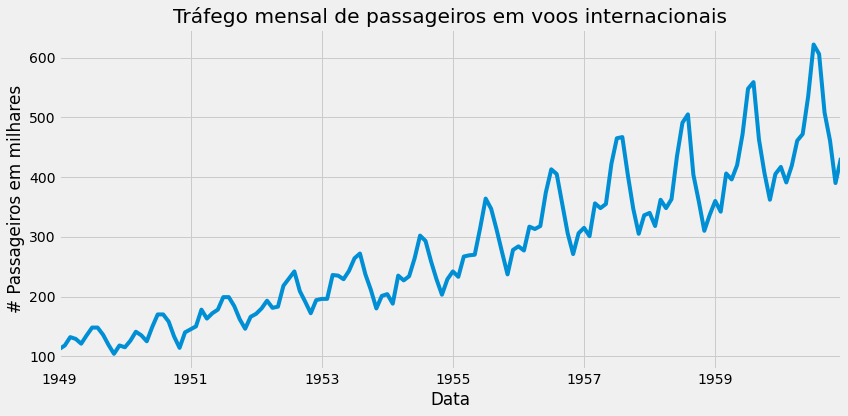

In [6]:
ax = df.plot(x='Mês', y='#Passageiros', figsize=(12, 6), title='Tráfego mensal de passageiros em voos internacionais', legend=False)
ax.set_ylabel('# Passageiros em milhares')
ax.set_xlabel('Data')
plt.tight_layout()

plt.savefig('../images/serie_airline.png', dpi=300)


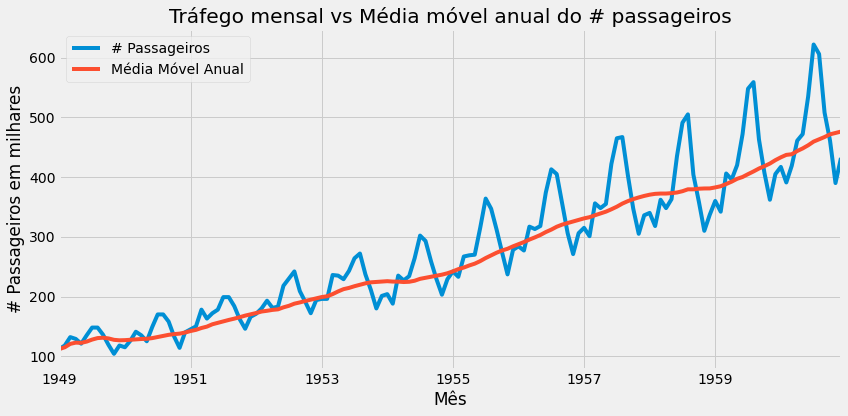

In [7]:
# Rolling window functions
rolling_air = df.copy()
rolling_air = rolling_air.set_index('Mês')
rolling_air = rolling_air['#Passageiros'].rolling('365D').mean()

ax = df.plot(x='Mês', y='#Passageiros', figsize=(12, 6), title='Tráfego mensal vs Média móvel anual do # passageiros', legend=False)
ax.set_ylabel('# Passageiros em milhares')
ax.set_xlabel('Data')

rolling_air.plot(figsize=(12, 6))

plt.legend(['# Passageiros', 'Média Móvel Anual'])
# Plotting a rolling mean of 90 day window with original High attribute of google stocks
plt.tight_layout()
plt.savefig('../images/serie_movel.png', dpi=300)
plt.show()

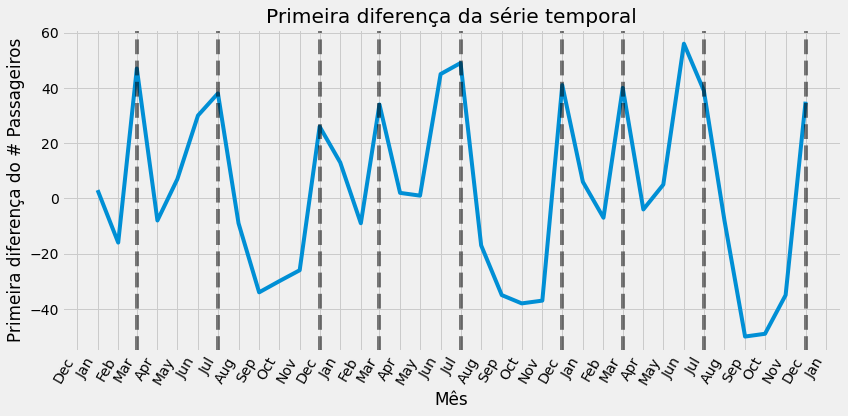

In [8]:
df_diff = df.copy()
df_diff = df_diff.set_index('Mês')
df_diff = df_diff.diff()
anos = ['1954', '1955', '1956']
df_diff = df_diff[min(anos): max(anos)]

ax = df_diff.plot(y='#Passageiros', figsize=(12, 6), title='Primeira diferença da série temporal', legend=False, x_compat=True)
_ = ax.set_ylabel('Primeira diferença do # Passageiros')

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
#ax.set_xticklabels(xlabels, Rotation=2)
# set monthly locator
ax.xaxis.set_major_locator(locator)
# set formatter
ax.xaxis.set_major_formatter(fmt)
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

ax.tick_params(axis='x', rotation=60)

for ano in anos:
    for mes in ['12', '3', '7']:
        ax.axvline(pd.Timestamp(f'{ano}-{mes}-01'), color='k', linestyle='--', alpha=0.5)
        
plt.tight_layout()
plt.savefig('../images/serie_1_diff.png', dpi=300)

* Parece que tem sazonalidade DEZ-JAN ---> CAI ----> JUL - SOBE, JUL

In [9]:
df_ts = df.set_index('Mês')

In [10]:
time_series = df['#Passageiros']

In [11]:
w_amostral = time_series.std()**2

In [12]:
w_amostral

14391.917200854703

In [13]:
from pydlm import modelTuner
myTuner = modelTuner(method='gradient_descent', loss='mse')

In [14]:
#percents = np.array([0.05, 0.1, 0.25, 0.5, 1])

In [15]:
#time_series[80:85] = -1

In [16]:
time_series

0      112
1      118
2      132
3      129
4      121
      ... 
139    606
140    508
141    461
142    390
143    432
Name: #Passageiros, Length: 144, dtype: int64

In [17]:
train = time_series[:132]
test = time_series[132:]

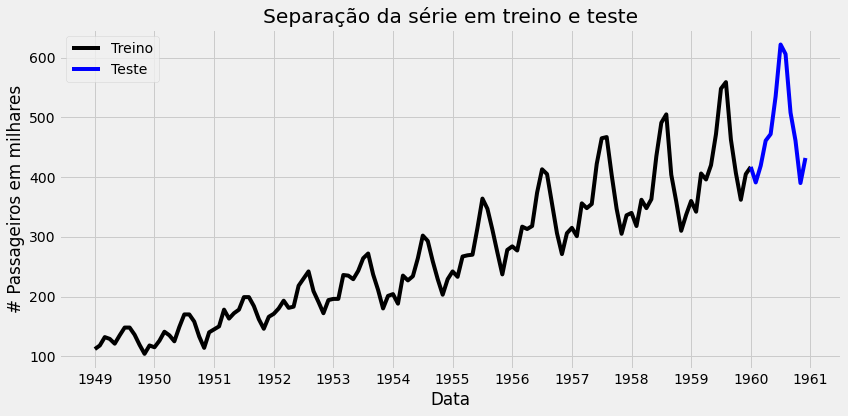

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Separação da série em treino e teste')
ax.set_ylabel('# Passageiros em milhares')
ax.set_xlabel('Data')

plt.xticks([i*12 for i in range(0, len(df['Mês'].dt.year.unique()) + 1)], df['Mês'].dt.year.unique().tolist() + [1961])

ax.plot(df.iloc[:133]['#Passageiros'], '-', color='k', label='Treino')
ax.plot(range(132, 144), test, color='blue', label='Teste')
ax.legend()
plt.tight_layout()
plt.savefig('../images/train_test.png', dpi=300)

In [19]:
df.iloc[130: 132]

,Mês,#Passageiros
130,1959-11-01,362
131,1959-12-01,405


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


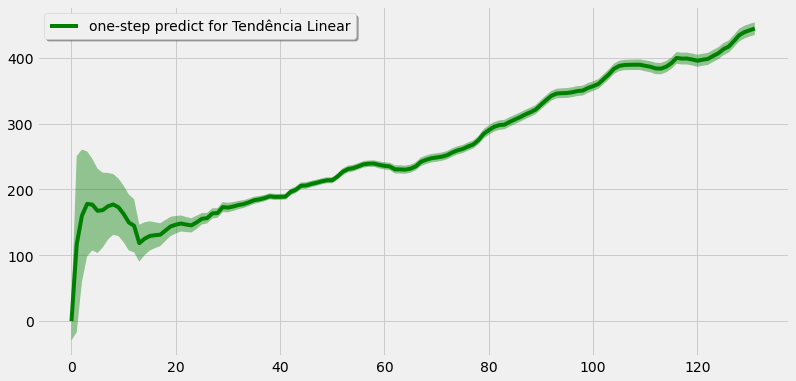

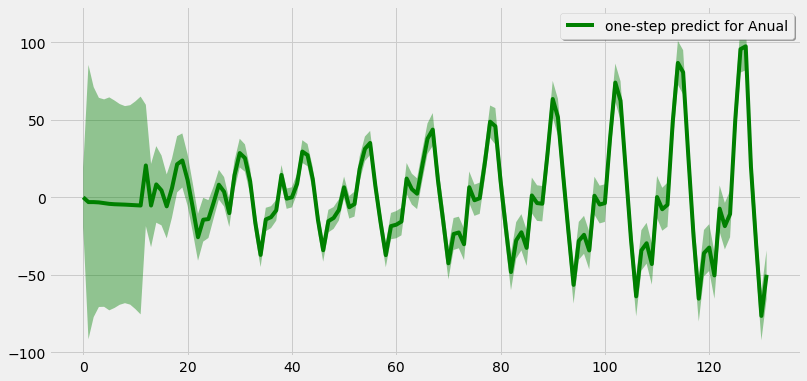

>>>>>>>>>>>>>>>>>>>>>>100 e MSE: 416.5063717666781


In [22]:
for w in [100]:    
    # A linear trend
    linear_trend = trend(degree=1, discount=0.9, name='Tendência Linear', w=w)
    # A seasonality
    yearly = seasonality(period=12, discount=0.95, name='Anual', w=w)

    # Build a simple dlm
    simple_dlm = dlm(time_series[:132]) + yearly + linear_trend
    
    simple_dlm.fit()
    #simple_dlm.plot('Tendência Linear')
    #simple_dlm.turnOff('filtered plot')
    
    simple_dlm.turnOff('smoothed plot')
    simple_dlm.turnOff('filtered plot')
    
    
    simple_dlm.plot('Tendência Linear')    
    simple_dlm.plot('Anual')
    print(f'>>>>>>>>>>>>>>>>>>>>>>{w} e MSE: {simple_dlm.getMSE()}')
    print('================================')

In [25]:
y_pred, variance = simple_dlm.predictN(N=12, date=131)
y_pred, variance = np.array(y_pred), np.array(variance)

In [26]:
# confidence interval
ci = 0.05*variance

In [27]:
ci

array([8.76262984, 8.7305508 , 8.69368439, 8.65133998, 8.60302827,
       8.54824807, 8.48651047, 8.41735864, 8.34038495, 8.25525245,
       8.16173532, 8.05985078])

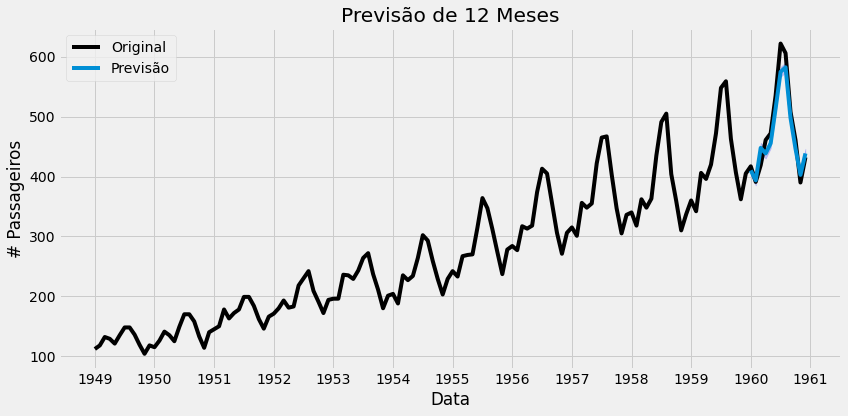

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Previsão de 12 Meses')
ax.set_ylabel('# Passageiros')
ax.set_xlabel('Data')
plt.xticks([i*12 for i in range(0, len(df['Mês'].dt.year.unique()) + 1)], df['Mês'].dt.year.unique().tolist() + [1961])

ax.plot(time_series.values, color='k', label='Original', alpha=1)
ax.plot(range(132, 144), y_pred, label='Previsão')
ax.fill_between(range(132, 144), (y_pred - ci), (y_pred + ci), color='blue', alpha=0.2)
ax.legend()
plt.tight_layout()
plt.savefig('../images/predict.png', dpi=300)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, mean_squared_error, r2_score

print(f'R2:{r2_score(test, y_pred)}\nMAE:{mean_absolute_error(test, y_pred)}\nMSE:{mean_squared_error(test, y_pred)}\nMSLE:{mean_squared_log_error(test, y_pred)}')

R2:0.9183008484309652
MAE:17.795302152459072
MSE:452.5701806957918
MSLE:0.0017170048761242576
